# **Estimating Home Values**

## Goals:
- Your customer the data science team wants to be able to predict the values of single unit properties that the tax district assesses using the property data from those whose last transaction was during the "hot months" (in terms of real estate demand) of May and June in 2017.

- They would also like to know the distribution of tax rates for each county.

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error

from math import sqrt


import explore
import wrangle
import split_scale
import model

## Acquire and Prep
(Planning and brainstorming was done in the zillow_scratchpad)
- Zillow dataframe is an SQL query from Zillow Database bringing in bed count(column name = bedroom_count), bathroom count (column name = batch_count), finished SqFt (column name = sqft), these 3 colomns will be our features and assessed home value (column name = assessed_tax_value) is what we are going to try to predict in our model
- I decided to drop outliers that are beyond 3 std's to help normalize the data
#### Also per the customers request:
    - bringing in a calculated field for Tax Rates (column name = tax_rate) which was calculated in SQL database using the taxamount column divided by the taxvaluedollarcnt column
    - merging FIPS database to obtain the county names (link provided in readme and essntial to reproducing this notebook)
    - creating 3 seperate dataframes to hold onto each counties tax properties to simplify exploration

In [2]:
zillow = wrangle.wrangle_zillow()

In [3]:
zillow.sample(4)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage
2769,2.0,4.0,1902.0,607000.0,0.012019,Los Angeles,CA,1.201852
12130,2.5,3.0,1281.0,461938.0,0.012089,Orange,CA,1.208924
11672,2.0,3.0,1812.0,446509.0,0.011209,Orange,CA,1.120896
10367,2.5,4.0,1823.0,313298.0,0.009530,Orange,CA,0.953035


In [4]:
zillow.shape

(13943, 8)

In [5]:
la_county = wrangle.la_county()

In [6]:
la_county.sample(4)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage
1223,2.0,4.0,1640.0,219000.0,0.018952,Los Angeles,CA,1.895224
7100,2.0,3.0,1390.0,159225.0,0.012623,Los Angeles,CA,1.262277
5733,3.0,4.0,3006.0,416094.0,0.019384,Los Angeles,CA,1.938353
5135,3.0,3.0,2855.0,403289.0,0.015207,Los Angeles,CA,1.520704


In [7]:
orange_county = wrangle.orange_county()

In [8]:
orange_county.sample(4)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage
12029,2.5,3.0,1677.0,654649.0,0.011357,Orange,CA,1.135735
10705,2.0,4.0,1637.0,59126.0,0.015532,Orange,CA,1.553191
10215,3.5,4.0,3705.0,725113.0,0.011346,Orange,CA,1.134596
12205,3.0,3.0,2096.0,567624.0,0.012536,Orange,CA,1.253633


In [9]:
ventura_county = wrangle.ventura_county()

In [10]:
ventura_county.sample(4)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage
14029,2.5,3.0,1760.0,528000.0,0.011561,Ventura,CA,1.156061
14540,3.0,3.0,2845.0,975000.0,0.010531,Ventura,CA,1.053087
14021,2.5,3.0,1762.0,603333.0,0.011137,Ventura,CA,1.113727
14560,3.5,4.0,2828.0,983000.0,0.010978,Ventura,CA,1.097849


# **Tax Rate Distributions**

This summary provides a quick glance at the mean ,median, max, min and average standard deviation of tax rate percentages within each county


In [11]:
explore.tax_summary()

,Mean Tax Rate %,Median Tax Rate %,Max Tax Rate %,Min Tax Rate %,AVG STD of Tax Rates
county_name,,,,,
Los Angeles,1.435265,1.276982,45.288365,0.111118,0.007920
Orange,1.220609,1.159212,10.735031,0.171235,0.003325
Ventura,1.207874,1.127094,29.486491,0.078687,0.008394



- After taking a look at this summary I found that Los Angels county has the most extreme outlier sitting at aproximtely 45% followed by Ventura county at aprroximately 29%
- The means for each county are very close with Los Angels being just slighlt higher

The below visualization shows the distrobutions of taxes so that I can easily identify where the bulk of the taxes are for each county as the customer has requested

**It is important to note that the y axis varies on each plot**

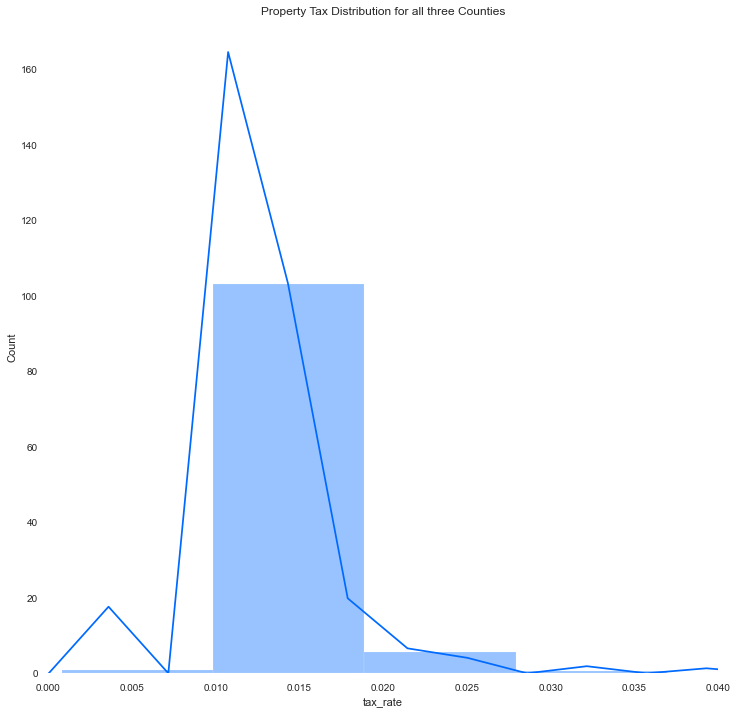

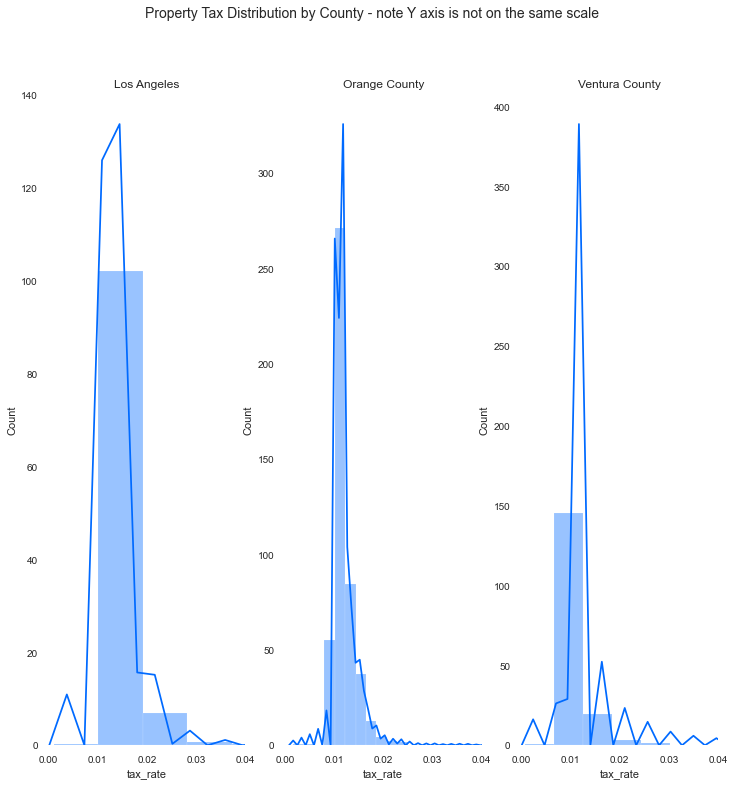

In [12]:
explore.tax_distro_visualization()

- First visualization which combines all 3 counties we see that the bulk of tax rates between 1% and roughly 1.9%
- Second visualization for Los Angels County shows us that the bulk of the tax rates are between 1% and roughly 1.9%
- Third visualization for Orange County has most of it's bulk at roughly 1%
- Fourth visualization for Ventura county has it's bulk between .9% and 1.2%

# **Building the MVP**

## Split the data for exploration and visualization
- Before exploring and visualizing the zillow data it has to be split into a train and test set to help ensure I do not overfit my model
    - I am using a seed of 123, which is the default for the function I have written
    - The split percentage is set at .7 which again is the default the function

In [13]:
train, test = split_scale.split_my_data(zillow)

In [14]:
train.sample(4)

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage
7452,3.0,6.0,2940.0,649759.0,0.012512,Los Angeles,CA,1.251195
14921,2.5,3.0,1719.0,241475.0,0.013051,Ventura,CA,1.305129
2416,2.0,4.0,1816.0,109923.0,0.018300,Los Angeles,CA,1.829990
2400,1.0,3.0,985.0,146850.0,0.016636,Los Angeles,CA,1.663643


In [15]:
train.shape

(9760, 8)

# Data Exploration

Here the use of a correlation chart will help me get sense of the numbers since my dataframe only has 4 coloumns at this point, and this will be followed by a pairplot to help me visualize the correlations. I will also be doing a bar plot to help me see if there is any correlation between counties and home values, which I stronglt suspect there is.

I will run a Pearson's R as well as a T-Test to validate/reject my hypothesis

- Set up some dataframes using our training dataset only
    - I prefer to set up my X_test and y_test at the end when evaluationg my model so that the variables are close to their function
    - my alpha will be at a 95% confidence

In [16]:
alpha = .05

In [17]:
mvp_df = train[["bath_count", "bedroom_count", "sqft", "assessed_tax_value"]]

In [18]:
X_train = train[["bath_count", "bedroom_count", "sqft"]]

In [19]:
y_train = train.assessed_tax_value

### Pearson's R
Run on on all 3 features against our predicted (home value)

### Initial Hypothesis
- $H_0$ - There is no linear correlation between home values and bathroom count, bedroom count, and SqFT
- $H_a$ - There is a linear correlation between home values and bathroom count, bedroom count, and SqFT

In [20]:
mvp_df.corr()

,bath_count,bedroom_count,sqft,assessed_tax_value
bath_count,1.000000,0.631930,0.827037,0.459222
bedroom_count,0.631930,1.000000,0.641974,0.261277
sqft,0.827037,0.641974,1.000000,0.523933
assessed_tax_value,0.459222,0.261277,0.523933,1.000000


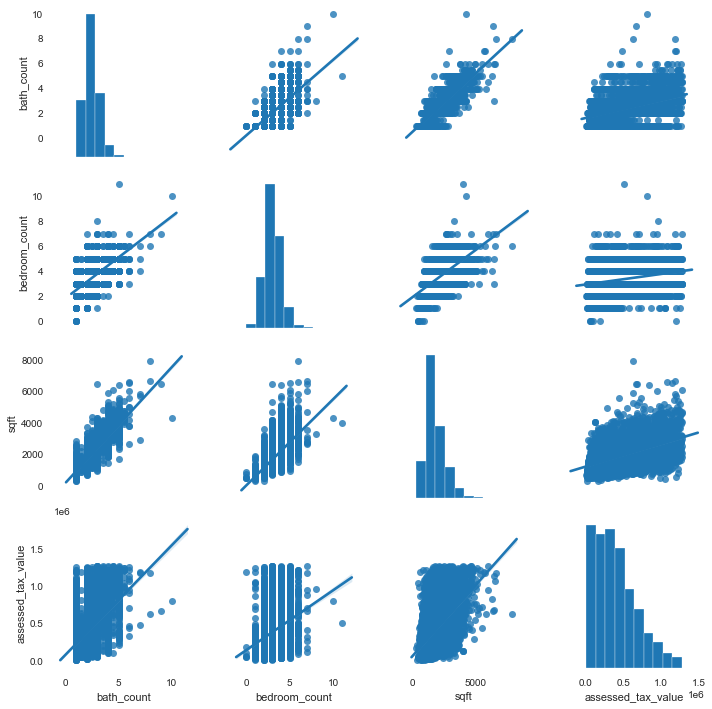

In [21]:
explore.plot_variable_pairs(mvp_df)

In [22]:
r_bath, p_bath = stats.pearsonr(mvp_df.bath_count, mvp_df.assessed_tax_value)

In [23]:
r_bedroom_count, p_bedroom_count = stats.pearsonr(mvp_df.bedroom_count, mvp_df.assessed_tax_value)

In [24]:
r_sqft, p_sqft = stats.pearsonr(mvp_df.sqft, mvp_df.assessed_tax_value)

In [25]:
if p_bath < alpha and p_bedroom_count < alpha and p_sqft < alpha:
    print("We reject the null hypothesis")
else:
    print("We fail to reject the null hypothesis")

We reject the null hypothesis


### T-Test
### Initial Hypothesis
- $H_0$ - There is no difference in overall average of home values and the average home value for each county
- $H_a$ - There is a difference in overall average of home values and the average home value for Los Angels County
- $H_a$ - There is a difference in overall average of home values and the average home value for Orange County
- $H_a$ - There is a difference in overall average of home values and the average home value for Ventura County

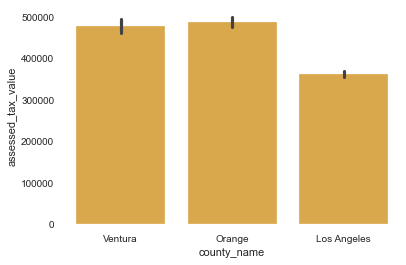

In [26]:
sns.barplot(y=train.assessed_tax_value, x=train.county_name, color="#f2af34ff")

#### T-Test for Orange County

In [27]:
train[train.county_name == "Orange"].assessed_tax_value.mean()

487302.20698822633

In [28]:
train[train.county_name == "Orange"].assessed_tax_value.median()

456261.0

In [29]:
t_oc, p_oc = explore.t_test_orange_county(train)

We reject the null hypothesis
t = 14.5
p = 1.25e-45


#### T-Test for Los Angeles County

In [30]:
t_la, p_la = explore.t_test_los_angeles_county(train)

We reject the null hypothesis
t = -13.1
p = 6.61e-39


#### T-test for Ventura County

In [31]:
t_v, p_v = explore.t_test_los_angeles_county(train)

We reject the null hypothesis
t = -13.1
p = 6.61e-39


#### Takeaways on exploration 
- it appears that the homes square footage plays the biggest role in home value
    - all features are also strongly related to sqft
- Bathroom count also seem to be a driver of home value

- As I had initialy thought the county does seem to play a role in driving home values and if time allows I will explore this further after the MVP has been completed

# Modeling
- Establish baseline using the mean home value (assessed_tax_value)
- Create Linear regression model to preedict y (home value):
    - Model for each feature (Sqft, bath count, bedroom count) seperately
    - Model for all three features
    - Select K model
- Create a predictions table for easy access to compare models

We split our X and y earlier so I will just list here to eliminate the need to scroll up
- X_train

- y_train

In [32]:
predictions = model.predictions_df(y_train)

In [33]:
sqft, n_bed, n_bath = model.get_2D_features_for_model(X_train)

#### Model for all 3 features

In [34]:
lm_all_3 = sklearn.linear_model.LinearRegression()
lm_all_3.fit(X_train, y_train)
predictions["Sqft_nbth_nbd_lm"] = lm_all_3.predict(X_train)

#### Select K best model

In [35]:
selector = SelectKBest(f_regression, k=2)
selector.fit(X_train, y_train)
X2 = selector.transform(X_train)
support = selector.get_support()
X_train.columns[support].tolist()

['bath_count', 'sqft']

In [36]:
kbest = train[["bath_count","sqft"]]
lm_kbest = sklearn.linear_model.LinearRegression()
lm_kbest.fit(kbest, y_train)
predictions["lm_kbest"] = lm_kbest.predict(kbest)

#### Model using sqft

In [37]:
lm_sqft = sklearn.linear_model.LinearRegression()
lm_sqft.fit(sqft, y_train)
predictions["sqft_lm"] = lm_sqft.predict(sqft)

#### Model using bedroom count

In [38]:
lm__nbed = sklearn.linear_model.LinearRegression()
lm__nbed.fit(n_bed, y_train)
predictions["n_bed_lm"] = lm_sqft.predict(n_bed)

#### Model using bath count

In [39]:
lm__n_bath = sklearn.linear_model.LinearRegression()
lm__n_bath.fit(n_bath, y_train)
predictions["n_bath_lm"] = lm_sqft.predict(n_bath)

In [40]:
predictions.head()

,actual,baseline,Sqft_nbth_nbd_lm,lm_kbest,sqft_lm,n_bed_lm,n_bath_lm
14202,369119.0,406615.066906,507441.189640,518058.410299,510751.770902,64098.493721,64098.493721
13648,98999.0,406615.066906,461591.668596,477275.024192,463905.333763,64098.493721,64098.493721
2997,352000.0,406615.066906,517836.222751,527304.846016,521372.825477,64098.493721,64098.493721
9892,939019.0,406615.066906,731414.303479,711881.159321,718241.658477,64098.493721,64098.493721
12320,371113.0,406615.066906,309505.357913,311543.983346,303830.868395,63908.832032,63908.832032


# Evaluate
Compare all models against the baseline and each other to determine which model is performin the best
- I will do this by:
    - plotting the residuals for each model
    - viewing the RMSE
    

#### RMSE

In [41]:
predictions.apply(lambda col: sqrt(sklearn.metrics.mean_squared_error(predictions.actual, col)))

actual                   0.000000
baseline            278200.814361
Sqft_nbth_nbd_lm    234558.737778
lm_kbest            236612.945568
sqft_lm             236960.130458
n_bed_lm            441343.258275
n_bath_lm           441343.258275
dtype: float64

Based on the RMSE it appears that the model with all features is performing the best closely followed by model for kbest and the model using sqft. Also the models for bedroom and bathroom performed worse than the baseline which was unexpected

#### Plotting Residuals

<Figure size 432x288 with 0 Axes>

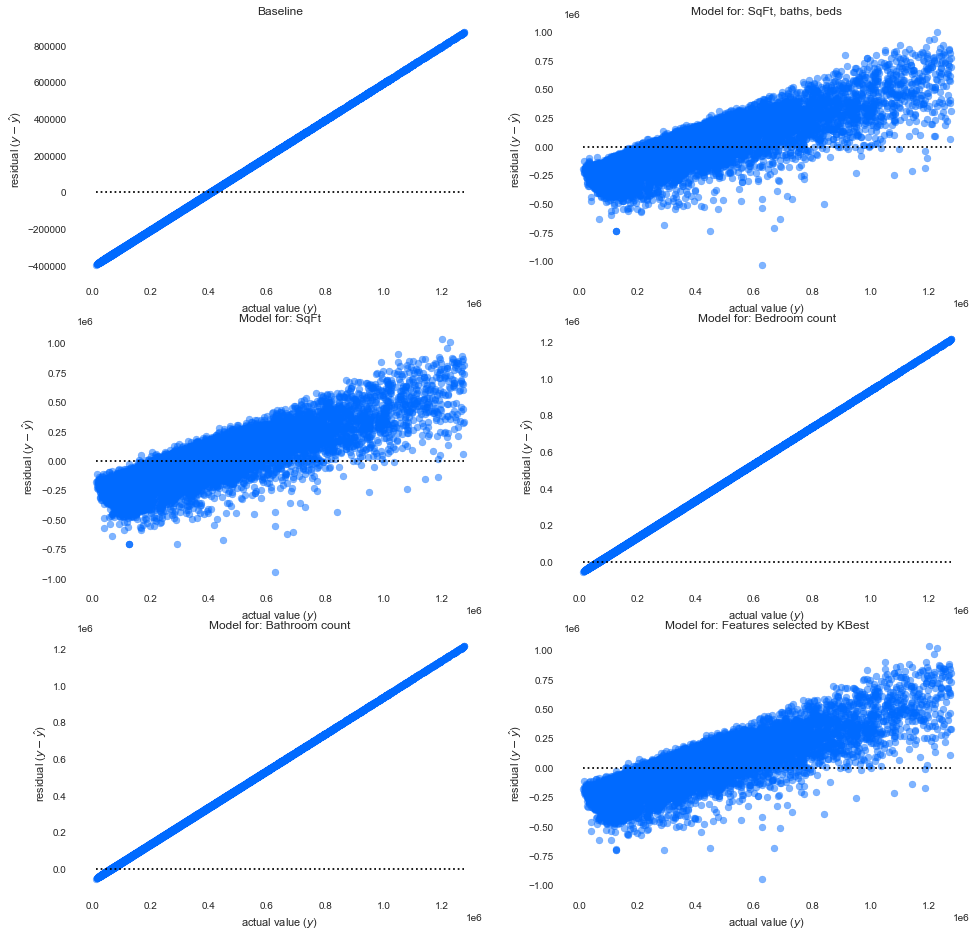

In [42]:
model.plot_all_residuals(predictions)

#### Takeaways on evaluation
- As observed in the exploratation the model that is performing best is the model which includes all 3 features of square footage, bathroom count and bedroom count
- There is an obvious trend in all the models indicating there may be some other driving factors for predicting home values, but as I currently have a model that is performing better than the baseline I will proceed with testing my model on the unseen data I sperated out earlier

# Testing the best model
- Based on the RMSE I have chosen to ho with the model that has all 3 features

In [43]:
test.head()

,bath_count,bedroom_count,sqft,assessed_tax_value,tax_rate,county_name,State,tax_percentage
7119,2.0,6.0,2384.0,502548.0,0.011897,Los Angeles,CA,1.189677
3119,2.0,3.0,1880.0,156553.0,0.020031,Los Angeles,CA,2.003053
7888,1.0,3.0,1144.0,245716.0,0.012470,Los Angeles,CA,1.247021
14975,2.0,4.0,1827.0,315169.0,0.011969,Ventura,CA,1.196888
4112,3.0,3.0,1838.0,393090.0,0.013291,Los Angeles,CA,1.329062


In [44]:
X_test = test[["bath_count", "bedroom_count", "sqft"]]
y_test = test.assessed_tax_value

In [45]:
df = model.predictions_df(y_test)

In [46]:
df.head(2)

,actual,baseline
7119,502548.0,407760.874014
3119,156553.0,407760.874014


In [47]:
X_test.head(2)

,bath_count,bedroom_count,sqft
7119,2.0,6.0,2384.0
3119,2.0,3.0,1880.0


In [48]:
test_predictions = lm_all_3.predict(X_test)

#### Plot the residuals

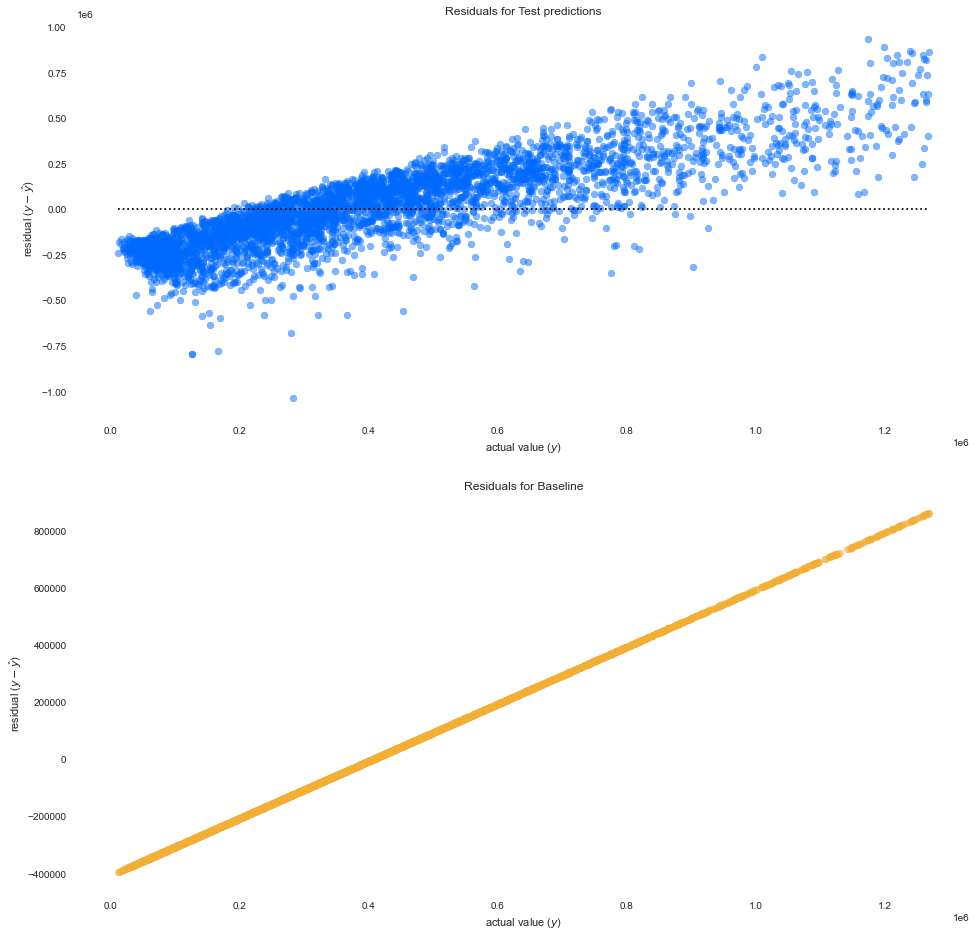

In [49]:
model.plot_test_residuals(df, test_predictions)

#### Baseline errors

In [50]:
SSE_bl, ESS_bl, TSS_bl, MSE_bl, RMSE_bl = model.regression_errors(y_test, df.baseline)

SSE= 328031591152342.6
ESS= 0.0
TSS= 328031591152342.6
MSE= 78420174791.38002
RMSE= 280036.02409579384


#### Model errors

In [51]:
SSE, ESS, TSS, MSE, RMSE = model.regression_errors(y_test, test_predictions)

SSE= 232387122923704.84
ESS= 88019703494839.69
TSS= 320406826418544.5
MSE= 55555133378.84409
RMSE= 235701.36482176784


In [52]:
if RMSE < RMSE_bl:
    print("The model performs better than the baseline")
else:
    print("Unfortunately the model did not perform better than the baseline and is of no value")

The model performs better than the baseline


# Conclusions
- My model performed better than the baseline with a RMSE of roughly $235,701
- Becasue the residual plot for my model shows a distinct pattern it is my belief that there are other factors driving the cost of home value, given more time I would explore different relationships and play with feature engineering
- It might aslo might be worth exploring a non-linear model to predict the home value
- I call this a useable model that can be improved on with time